# Loading & Preprocessing

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('Lending_Club_v2.csv')
bad_indicators = ["Charged Off ","Charged Off","Default",
                  "Does not meet the credit policy. Status:Charged Off",
                  "In Grace Period","Default Receiver","Late (16-30 days)",
                  "Late (31-120 days)"]
target = df['loan_status'].isin(bad_indicators).astype(int) 

# Drop empty columns
df = df.dropna(axis=1, how='all')
# Non-predictive, too few nonzero values, or cause intractable feature bloat
to_drop = ['id','desc','loan_status','zip_code','emp_title','title',
           'acc_now_delinq','delinq_amnt','addr_state','last_pymnt_d',
           'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line','issue_d']
# Settlement variables would cause leakage
to_drop = to_drop+[x for x in df.columns if 'settlement' in x]
# Drop cols with only one non-NaN value, uninformative
unique_counts = df.nunique()
to_drop = to_drop+[x for x in df.columns if unique_counts[x]==1]

df = df.drop(columns=to_drop)

# Finally, drop columns with too many (1000+) missing values, so we 
# can dropna() and be able to use PCA
df = df.drop(columns=df.isna().sum(axis=0).sort_values(ascending=False)[:5].index).dropna()
print(df.shape)

# Now remove strings from and recast numeric columns
df[['int_rate','revol_util']] = df[['int_rate','revol_util']].replace('%', '', regex=True).astype(float)/100
df['term'] = df['term'].replace(' months','',regex=True).astype(float)

grade_mapping={'G':1, 'F':2, 'E':3, 'D':4, 'C':5, 'B':6, 'A':7}
subgrade_map = {str(k): k*0.4 for k in range(1,6)}
df['grade'] = df['grade'].map(lambda x: grade_mapping[x] if str(x) != 'nan' else x)
df['sub_grade'] = df['sub_grade'].map(lambda x: subgrade_map[x[1]] if str(x) != 'nan' else x)+df['grade']


# Create dummies
dummy_cols = ['home_ownership','verification_status','purpose']
df = pd.get_dummies(df, columns=dummy_cols)

df['target'] = target # So it will be last on the corrplot

# Since we have a lot of data, we'll use regular cross-val instead
# of k-folds, in the interest of time. Do a standard 70-20-10 split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],train_size=0.9,
                                                    stratify=df['target'])
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=7/9,
                                                  stratify=y_train)

(42445, 28)


# EDA

To visualize:
* Heatmap/histogram of target vs things like amount, grade and sub_grade, int_rate, installment, income, home ownership, purpose, verification status
* Correlation plot between continuous variables and target
* Violin plot of select variables with target: group interest rate, loan amount into bins.
* positive-ratio of target vs loan year?

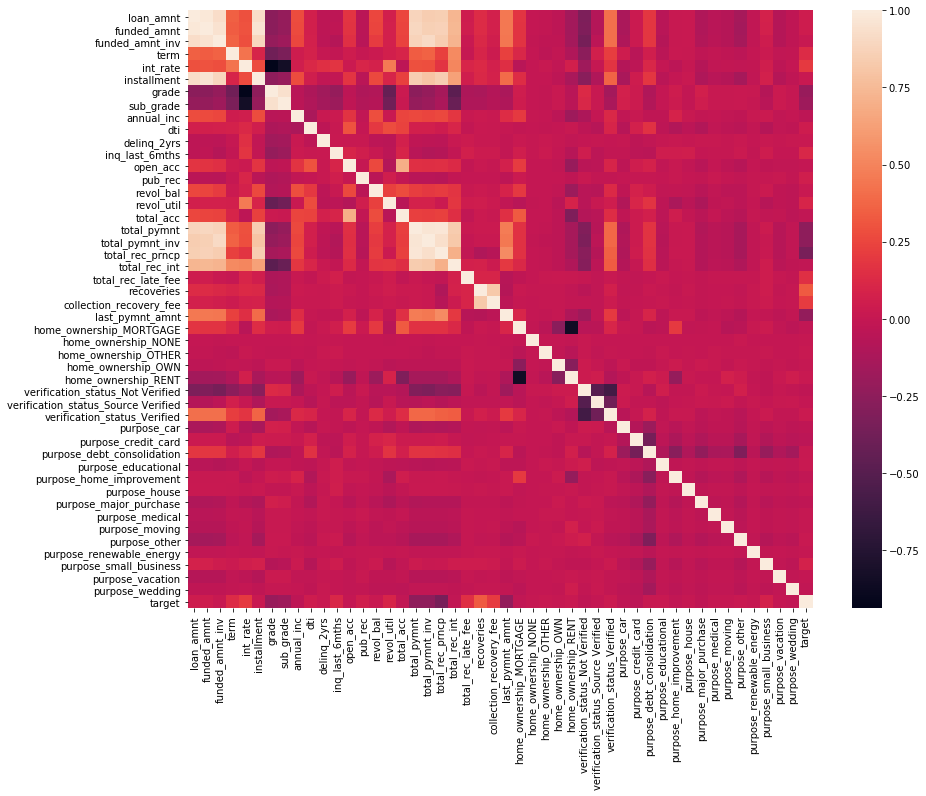

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(14,11))
corr = df.corr()
sns.heatmap(df.corr(), xticklabels=corr.columns, yticklabels=corr.columns)

The first three features are very nearly the same, so we can remove them to avoid issues of multicollinearity, as well as simply redundancy. We'll keep funded_amnt, as that is the most relevant quantity from the perspective of both the client and the business. 

Installment looks the same as those three, but actually differs in its interactions with other features, so it is kept distinct.

Next let's inspect how variables correlate with the target. We see the expected negative correlation with grade and subgrade (that is, higher grade is associated with a lower likelihood of default). Late fees and recoveries make the target more likely, while total payment on the loan and interest make it less likely. Higher terms and interest rates also have a clear positive correlation with the target; as do instances of recoveries. Of these three, interest rate and recoveries make intuitive sense, but term is interesting. Perhaps this has to do with term's positive correlation with features such as interest rate and loan amount; it *is* natural that term would be dependent on these.

In general, most variables do not have strong correlations with the target: this could be explored more with feature importance or feature subsets to determine how those feature affect a model's predictions.

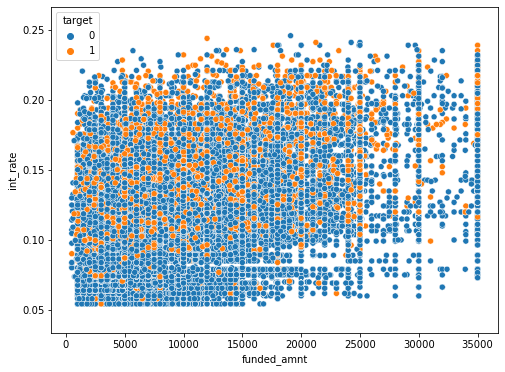

In [3]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot('funded_amnt', 'int_rate', hue='target', data=df)

There isn't much that immediately jumps out between the interaction of funded amount, interest rate, and the target. The one trend we can ascertain here is that clients with low interest rates (< ~8%) rarely default, regardless of the loan amount. This plot does, however, show relative sparsity in the data at the upper echelons of funded amount, particularly with low interest rates. This is something to be cautious of when using our model. The same might be said to a lesser extent regard interest rates above ~22%.

Next let's get a handle on the distributions of the variables most clearly correlated with the target per the heatmap

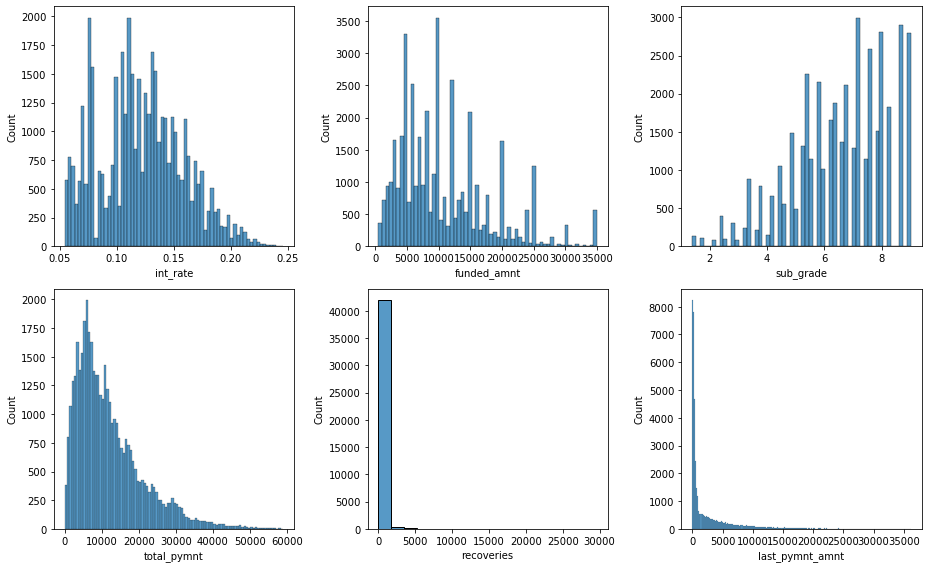

In [7]:
fig, ax = plt.subplots(2,3,figsize=(13,8))
i = 0
for col in ['int_rate','funded_amnt','sub_grade','total_pymnt','recoveries','last_pymnt_amnt']:
    sns.histplot(df[col], ax=ax[i//3, i%3])
    i += 1
plt.tight_layout()

Skewed distributions about, but we'll normalize our data for feature reduction anyhow. The generally low value of recoveries is interesting, however, given its positive association with the target. Those with high recoveries may be the driving force of this association.

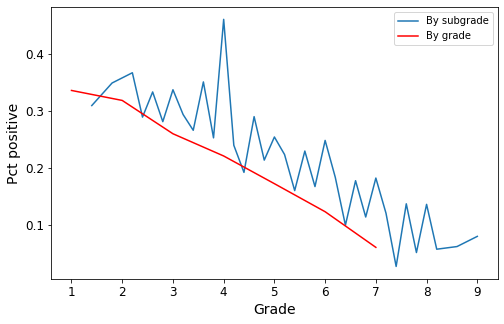

In [8]:
temp = df.groupby('sub_grade')['target'].agg(['count','sum'])
ratio1 = temp['sum']/temp['count']
temp = df.groupby('grade')['target'].agg(['count','sum'])
ratio2 = temp['sum']/temp['count']
fig = plt.figure(figsize=(8,5))
sns.lineplot(sorted(df['sub_grade'].unique()), ratio1, label='By subgrade')
sns.lineplot(sorted(df['grade'].unique()), ratio2, color='r', label='By grade')

plt.xlabel('Grade', size=14)
plt.ylabel('Pct positive', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

There is a clear downward trend with respect to ratio of positives when we group the data by subgrade. The noise is to be expected as there are many other factors at play. The curse is much smoother when grouped by simple grade, indicating that we should be somewhat suspicious of subgrades - such precise qualitative scoring must be difficult to refine, after all.

# Feature reduction

Since we have mixed numerical and categorical data, we could use Factor Analysis of Mixed Data (FAMD) for feature reduction. However, since we transformed the data to numeric already, PCA will work. Since this transformation was requested, I'll only use PCA here, though in another environment I would experiment with FAMD as well.

I realize that there was a section regarding feature selection. However, I approach feature selection differently when performing PCA: less-importnat features will simply end up being components of PCA dimensions corresponding to low eigenvalues, so I select based on the eigenvalues instead.

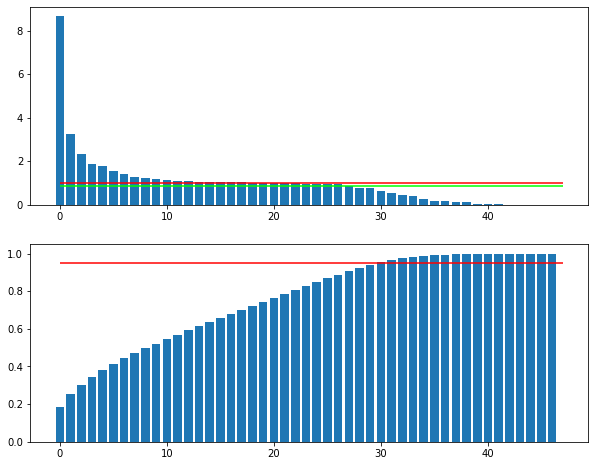

[8.65617081e+00 3.26358205e+00 2.34265299e+00 1.86626668e+00
 1.78781946e+00 1.52942464e+00 1.39287061e+00 1.27320150e+00
 1.22769335e+00 1.17545046e+00 1.11744050e+00 1.09701378e+00
 1.06531574e+00 1.05627517e+00 1.03504264e+00 1.03048290e+00
 1.02155796e+00 1.01692581e+00 1.00964398e+00 1.00635204e+00
 1.00188189e+00 9.98306550e-01 9.88825898e-01 9.68742975e-01
 9.62847897e-01 9.48253237e-01 9.26411227e-01 8.69087381e-01
 7.76513963e-01 7.58919749e-01 6.36069073e-01 5.17539168e-01
 4.39608031e-01 3.72355240e-01 2.67455703e-01 1.71111395e-01
 1.46319097e-01 1.19599620e-01 9.95212062e-02 2.77739637e-02
 2.04339060e-02 9.37320127e-03 3.44851924e-03 5.02896555e-14
 3.15930768e-31 1.40925090e-31 8.27888679e-32]


In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
scaler.fit(X_train)
X_train_tran = scaler.transform(X_train)

pca = PCA()
pca.fit(X_train_tran)
fig, ax = plt.subplots(2,1,figsize=(10,8))
ax[0].bar(range(len(pca.explained_variance_)), pca.explained_variance_)
ax[0].hlines(y=[np.mean(pca.explained_variance_), 0.1*pca.explained_variance_[0]],
           xmin=0, xmax=len(pca.explained_variance_), colors=['r','lime'])
ax[1].bar(range(len(pca.explained_variance_)), np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_))
ax[1].hlines(y=0.95, xmin=0, xmax=len(pca.explained_variance_), color='r')
plt.show()
print(pca.explained_variance_)

The first plot shows the magnitudes of principal components, while the second shows the cumulative fraction of variance exaplained by the first *x* pricipal components. There is no clear falloff point, so we turn to other heuristics to decide how many dimensions to keep. Among these are:

* Choose all eigenvalues above the mean
* Choose all eigenvalues above a certain percentile
* Choose enough eigenvalues to explain some percent of the variance

We can afford to take most of the principal components here since there's only 46, so let's try to explain 95% of the variance:

In [10]:
np.where(np.cumsum(pca.explained_variance_)/np.sum(pca.explained_variance_) > 0.95)

(array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46],
       dtype=int64),)

With 31 principal components we get 95% of the variance. This will be our cutoff.

In [11]:
X_train_red = pca.transform(X_train_tran)[:, :31]
X_val_red = pca.transform(scaler.transform(X_val))[:, :31]
X_test_red = pca.transform(scaler.transform(X_test))[:, :31]

# XGBoost

To tune an XGBoost classifier, we'll use hyperopt, a Bayesian optimization package. We will also use oversampling when training to make up for class imbalance. Random over sampling is employed for simplicity, though SMOTE and its variants would be worth a try.

In [12]:
from xgboost import XGBClassifier
from hyperopt import Trials, fmin, tpe, space_eval, hp
from functools import partial
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline
ros = RandomOverSampler() 

def xg_objective(params, pipe, X, y, Xval, yval, scoring):
    pipe.set_params(**params)
    pipe.fit(X, y)
    score = roc_auc_score(yval, pipe.predict(Xval))
    return 1-score

cat_feats = []
xg = XGBClassifier()
xg_pipe = Pipeline([('upsample', ros),('model', xg)])

xg_space = {'model__n_estimators': hp.choice('model__n_estimators', range(60,160)),
            'model__eta': hp.uniform('model__eta',0.01,0.3),
            'model__max_depth ': hp.choice('model__max_depth', range(3,15)),
            'model__reg_lambda': hp.uniform('model__reg_lambda',0.001, 1.0)}
xg_trials = Trials()
xg_partial = partial(xg_objective, pipe=xg_pipe, X=X_train_red, y=y_train,
                     Xval=X_val_red, yval=y_val, scoring='roc_auc_score')
best = fmin(fn=xg_partial, space=xg_space, algo=tpe.suggest, max_evals=50,
            trials=xg_trials)
best_params = space_eval(xg_space, best)

100%|████████████████████████████████████████████████| 50/50 [09:54<00:00, 11.90s/trial, best loss: 0.1452127059690408]


# Evaluation

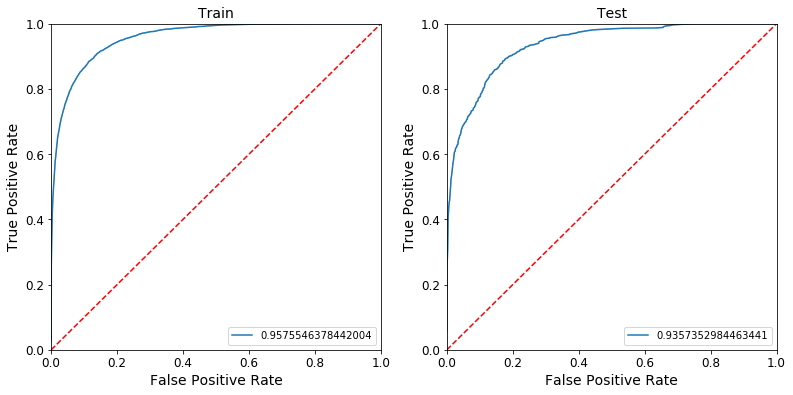

TRAINING RESULTS:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94     32432
           1       0.60      0.87      0.71      5768

    accuracy                           0.89     38200
   macro avg       0.79      0.88      0.82     38200
weighted avg       0.92      0.89      0.90     38200
Accuracy:0.8940052356020942

TEST RESULTS:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      3604
           1       0.57      0.79      0.66       641

    accuracy                           0.88      4245
   macro avg       0.77      0.84      0.79      4245
weighted avg       0.90      0.88      0.89      4245
Accuracy:0.8784452296819788


In [13]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

xg_pipe.set_params(**best_params)
X_train_red_all = np.concatenate([X_train_red, X_val_red])
y_train_all = pd.concat([y_train, y_val])
xg_pipe.fit(X_train_red_all, y_train_all)

preds_train = xg.predict_proba(X_train_red_all)[:,1] 
preds_test = xg.predict_proba(X_test_red)[:,1]
fpr_tr, tpr_tr, threshold_tr = roc_curve(y_train_all, preds_train)
fpr_te, tpr_te, threshold_te = roc_curve(y_test, preds_test)

fig, axs = plt.subplots(1,2,figsize=(13,6))
axs[0].set_title('Train', size=14)
axs[1].set_title('Test', size=14)
sns.lineplot(fpr_tr, tpr_tr, label=roc_auc_score(y_train_all, preds_train), ax=axs[0])
sns.lineplot(fpr_te, tpr_te, label=roc_auc_score(y_test, preds_test), ax=axs[1])

for ax in axs:
    ax.plot([0, 1], [0, 1],'r--')
    ax.set_xlim([0, 1.0])
    ax.set_ylim([0, 1.0])
    ax.set_ylabel('True Positive Rate', size=14)
    ax.set_xlabel('False Positive Rate', size=14)
    ax.tick_params(labelsize=12)
plt.show()

bin_preds_train = xg_pipe.predict(X_train_red_all)
bin_preds_test =  xg_pipe.predict(X_test_red)
    
print(f"TRAINING RESULTS:\n{classification_report(y_train_all, bin_preds_train)}"
      f"Accuracy:{accuracy_score(y_train_all, bin_preds_train)}\n")
print(f"TEST RESULTS:\n{classification_report(y_test,bin_preds_test)}"
      f"Accuracy:{accuracy_score(y_test, bin_preds_test)}")

Not bad for a weekend of work! Test AUC of 0.94 is pretty solid, though there are a couple unfortunate things about this model. First is a lack of explainability due to feature reduction, especially given the importance of having reasons when you deny someone a loan. Second is precision: the model clearly predicted a lot of false-positives. This is ostensibly tolerable, though, since false negatives are more costly from a business standpoint. There's a debate to be had about how much of either error can be tolerate to the benefit of the other, but that's a conversation that we need a cost-confusion matrix to have. 

# Future directions

With more time I would do the following:

* Explore different upsampling methods/fractions - a 1:1 ratio might not be ideal, and SMOTE could be better given our abundance of data for SMOTE to fit its nearest-neighbors method.
* Try different models - LightGBM, catboost, random forest. The first two in particular are known for their support of categorical features, which were common enough in this dataset to make them attractive options.
* Try factor analysis of mixed data (FAMD) instead of PCA. This technique combines PCA and MCA (essentially PCA for categorical data). Using this would allow us to skip encoding of categorical features and still use XGBoost, though encoding made it unncessary. It remains an alternate approach worth trying.
* Attempt robust feature selection so that we could implement prediction explainability such as SHAP, rather than relying on feature reduction which hurts intepretability of the model. I would have done this using feature importance from a baseline XGBoost model, tuned in the same manner.
* Attempt imputation of missing features. Regression imputing, i.e. based on loan amount and grade, would work well to impute interest rate, for instance.
* Do before/after models for upsampling, feature reduction/selection, etc to demonstrate how they improve the score.